In [12]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import numpy as np

关于CIFAR10数据集的详解请看这篇[Blog](https://lry89757.github.io/2021/08/06/cifar10-shu-ju-ji-ji-du-qu/) 以及[官网描述](https://www.cs.toronto.edu/~kriz/cifar.html)

In [13]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()
print(t.__version__)

1.8.1+cpu


In [14]:
class Net(nn.Module):
    
    def __init__(self) -> None:
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
for name, param in net.named_parameters():
    print(name, ":", param.size())

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


In [16]:
tes = t.randn(8, 3, 32, 32)
out = net(tes)
print(out)

tensor([[ 0.0677,  0.1502, -0.0055,  0.1050,  0.0959, -0.1905,  0.0844, -0.0324,
          0.0730, -0.0298],
        [ 0.0778,  0.1471,  0.0155,  0.1041,  0.1194, -0.1852,  0.0761, -0.0400,
          0.0660, -0.0303],
        [ 0.0562,  0.1496, -0.0005,  0.0882,  0.0963, -0.1889,  0.0854, -0.0490,
          0.0740, -0.0295],
        [ 0.0626,  0.1478,  0.0102,  0.0959,  0.1096, -0.1935,  0.0789, -0.0502,
          0.0782, -0.0353],
        [ 0.0721,  0.1575,  0.0077,  0.1043,  0.1042, -0.2035,  0.0890, -0.0455,
          0.0693, -0.0536],
        [ 0.0670,  0.1537,  0.0146,  0.1144,  0.1136, -0.1939,  0.0950, -0.0248,
          0.0489, -0.0373],
        [ 0.0417,  0.1490, -0.0018,  0.1106,  0.0964, -0.1643,  0.0791, -0.0562,
          0.0757, -0.0729],
        [ 0.0555,  0.1175, -0.0034,  0.1048,  0.1084, -0.1375,  0.0868, -0.0310,
          0.0793, -0.0514]], grad_fn=<AddmmBackward>)


In [17]:
net.zero_grad()
target = t.randn(8, 10)
criterion = nn.MSELoss()
loss = criterion(out, target)
loss.backward()
print(net.conv1.bias.grad)

tensor([ 0.0095,  0.0004,  0.0087, -0.0007,  0.0033,  0.0032])


In [18]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
output = net(tes)
loss = criterion(output, target)
loss.backward()
print(net.conv1.bias)
optimizer.step()
print(net.conv1.bias)

Parameter containing:
tensor([-0.0044, -0.0807,  0.0816,  0.0347,  0.1017, -0.0018],
       requires_grad=True)
Parameter containing:
tensor([-0.0045, -0.0807,  0.0815,  0.0347,  0.1017, -0.0019],
       requires_grad=True)


首先是

In [19]:
# 数据预处理，相当于提前定义了怎么处理数据：
# 因为读入的数据为numpy格式，所以我们要先将其转换为tensor格式，
# 然后对其进行归一化，有三个通道需要归一化，而第一个为均值，第二个为标准差
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集
trainset = tv.datasets.CIFAR10(
    root='/pytorch/Data/',
    train=True,
    download=False,
    transform=transform
)

# 迭代器
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

# 测试集
testset = tv.datasets.CIFAR10(
    root='/pytorch/Data/',
    train=False,
    download=False,
    transform=transform
)

# 迭代器
testloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

Dataset对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。

ship


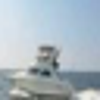

In [20]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

In [35]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

plane       frog       frog       horse


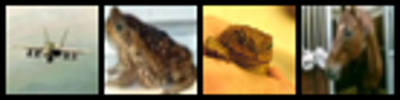

In [22]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('       '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

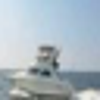

In [23]:
show(((data+1)/2)).resize((100, 100))

## 数据处理部分

In [24]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 读取训练集
trainset = tv.datasets.CIFAR10(
    root='/pytorch/Data',
    download=False,
    train=True,
    transform=transform
)

# about DataLoader:
# https://www.programcreek.com/python/example/100891/torch.utils.data.DataLoader
# https://blog.csdn.net/weixin_43914889/article/details/104677675?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522162830497416780269880390%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=162830497416780269880390&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~top_click~default-2-104677675.first_rank_v2_pc_rank_v29&utm_term=torch.utils.data.DataLoader&spm=1018.2226.3001.4187
trainloader = t.utils.data.DataLoader(
    trainset,
    shuffle=True,
    batch_size=4,
    num_workers=2     # 好像指代的是线程数，我们最多可以设置为8.
)


# 读取测试集
testset = tv.datasets.CIFAR10(
    root='/pytorch/Data',
    download=False,
    train=False,
    transform=transform
)

testloader = t.utils.data.DataLoader(
    testset,
    shuffle=True,
    batch_size=4,
    num_workers=2
)

In [25]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

plane


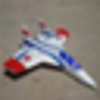

In [26]:
img, label = trainset[30]
print(classes[label])
show((img+1)/2).resize((100, 100))  # 不要矩阵是normalized， 我们应该先将其还原

plane     truck     ship     dog


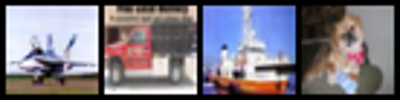

In [27]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('     '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

In [28]:
print(img.size())

torch.Size([3, 32, 32])


In [29]:
print(net(img.view(1, 3, 32, 32)))

tensor([[ 0.0333,  0.1434, -0.0742,  0.0302,  0.0789, -0.1317, -0.0049, -0.0014,
          0.1080, -0.0073]], grad_fn=<AddmmBackward>)


In [30]:
net.zero_grad()

In [31]:
net.conv1.bias.grad

tensor([0., 0., 0., 0., 0., 0.])

In [32]:
# 误差
criterion = nn.CrossEntropyLoss()   # 采用交叉熵
# 优化器
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)   # SGD优化算法

In [33]:
# 训练网络
epoches = 3
t.set_num_threads(8)   # 设置pytorch多线程运算时占用的线程数https://blog.csdn.net/jacke121/article/details/84305727?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522162830660116780357276701%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=162830660116780357276701&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-1-84305727.first_rank_v2_pc_rank_v29&utm_term=torch.set_num_threads&spm=1018.2226.3001.4187
for epoch in range(epoches):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        target = net(images)

        loss = criterion(target, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        if i % 1999 == 0:
            print(f'epoch: {epoch+1}   samples: {i/1999 * 2000} loss: {running_loss / 20000}')
            running_loss = 0.0

epoch: 1   samples: 0.0 loss: 0.00011331702470779419
epoch: 1   samples: 2000.0 loss: 0.223616419506073
epoch: 1   samples: 4000.0 loss: 0.19101078568995
epoch: 1   samples: 6000.0 loss: 0.1681240275606513
epoch: 1   samples: 8000.0 loss: 0.16075783373117447
epoch: 1   samples: 10000.0 loss: 0.15282194568514823
epoch: 1   samples: 12000.0 loss: 0.15065905435979365
epoch: 2   samples: 0.0 loss: 6.625069379806518e-05
epoch: 2   samples: 2000.0 loss: 0.14071672067493202
epoch: 2   samples: 4000.0 loss: 0.1384790808044374
epoch: 2   samples: 6000.0 loss: 0.13674074270054698
epoch: 2   samples: 8000.0 loss: 0.13151871077008545
epoch: 2   samples: 10000.0 loss: 0.13130651690885425
epoch: 2   samples: 12000.0 loss: 0.12829094748366623
epoch: 3   samples: 0.0 loss: 5.245709419250488e-05
epoch: 3   samples: 2000.0 loss: 0.12147029370293021
epoch: 3   samples: 4000.0 loss: 0.12117388775348663
epoch: 3   samples: 6000.0 loss: 0.12140363073199988
epoch: 3   samples: 8000.0 loss: 0.1169104343287646

In [36]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 58 %
